## Imports

In [21]:
# if necessary to install all the packages, run:
# !pip install -r requirements.txt

In [1]:
%load_ext lab_black

from autorank import autorank, plot_stats, create_report, latex_table

import sdgym
from sdv.metadata import SingleTableMetadata
from sdv.single_table import (
    CTGANSynthesizer,
    TVAESynthesizer,
    GaussianCopulaSynthesizer,
    CopulaGANSynthesizer,
)
from sdv.lite import SingleTablePreset
from sdv.evaluation.single_table import (
    evaluate_quality,
    get_column_plot,
    get_column_pair_plot,
    run_diagnostic,
)
from sdv.sampling import Condition

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import warnings
import time
import os
import json
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    f1_score,
    precision_score,
)
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
sns.set(style="darkgrid", font_scale=0.5)
custom_palette = ["#8b4513", "#90ee90", "#545454", "#6a287e", "#f0be00"]
sns.set_palette(custom_palette)

C:\Users\caio_barros\AppData\Local\Temp\ipykernel_27484\2544458151.py:24: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Funções

In [2]:
def dummy(df, columns):
    dummy_variables = []
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        dummy_variables.append(dummies)
    return dummy_variables

In [12]:
def adjust_dataframe(df):
    df["booking_status"].replace("Not_Canceled", 0, inplace=True)
    df["booking_status"].replace("Canceled", 1, inplace=True)

    df["type_of_meal_plan"].replace(
        {"Not Selected": 0, "Meal Plan 1": 1, "Meal Plan 2": 2, "Meal Plan 3": 3},
        inplace=True,
    )
    df["room_type_reserved"].replace(
        {
            "Room_Type 1": 1,
            "Room_Type 2": 2,
            "Room_Type 3": 3,
            "Room_Type 4": 4,
            "Room_Type 5": 5,
            "Room_Type 6": 6,
            "Room_Type 7": 7,
        },
        inplace=True,
    )
    df["market_segment_type"] = df["market_segment_type"].map(
        {"Offline": 0, "Online": 1, "Corporate": 2, "Aviation": 3, "Complementary": 4}
    )

    df = df.apply(pd.to_numeric, errors="coerce")

    return df

In [4]:
def evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True):
    if standardscaler:
        scaler = StandardScaler().fit(X_train)
    else:
        scaler = MinMaxScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = [
        ("SVM", SVC(), {"C": [0.1, 0.5, 1, 5, 10], "kernel": ["linear", "rbf"]}),
        (
            "Decision Tree",
            DecisionTreeClassifier(),
            {"max_depth": [None, 1, 2, 5, 10], "min_samples_split": [2, 3, 4, 5, 10]},
        ),
        (
            "KNN",
            KNeighborsClassifier(),
            {"n_neighbors": [1, 2, 3, 4, 5, 7, 10], "weights": ["uniform", "distance"]},
        ),
        (
            "Random Forest",
            RandomForestClassifier(),
            {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]},
        ),
        (
            "Logistic Regression",
            LogisticRegression(max_iter=1000),
            {"C": [0.1, 0.5, 1, 5, 10], "solver": ["liblinear", "sag", "saga"]},
        ),
        (
            "MLP",
            MLPClassifier(max_iter=1000),
            {"hidden_layer_sizes": [(100,), (100, 50)], "alpha": [0.0001, 0.001, 0.01]},
        ),
    ]

    results = []

    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model, param_grid in models:
        start_time = time.time()

        clf = GridSearchCV(model, param_grid, cv=stratified_cv)
        clf.fit(X_train_scaled, y_train)

        best_model = clf.best_estimator_
        best_params = clf.best_params_

        y_pred = best_model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        execution_time = time.time() - start_time

        results.append(
            {
                "Classificador": name,
                "Acurácia": accuracy,
                "Precisão": precision,
                "F1 Score": f1,
                "ROC/AUC": roc_auc,
                "Tempo": execution_time,
                "Best Parameters": best_params,
            }
        )

    results_df = pd.DataFrame(results)
    return results_df

In [5]:
def plot_confusion_matrix(model, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)

    fig = sp.make_subplots(rows=1, cols=1)

    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=classes,
            y=classes,
            colorscale="Blues",
            reversescale=True,
            showscale=False,
            hoverongaps=False,
            hovertemplate="Actual: %{y}Predicted: %{x}Count: %{z}",
        )
    )

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                dict(
                    x=classes[j],
                    y=classes[i],
                    text=str(cm[i, j]),
                    showarrow=False,
                    font=dict(color="black"),
                )
            )

    fig.update_layout(
        title="Confusion Matrix", width=600, height=500, annotations=annotations
    )

    fig.update_xaxes(title_text="Predicted")
    fig.update_yaxes(title_text="Actual")

    fig.show()

In [6]:
def plot_categorical_balance(data, cat_features):
    plt.figure(figsize=(10, 20))
    rows = len(cat_features)
    cols = 2

    for i, feature in enumerate(cat_features, start=1):
        plt.subplot(rows, cols, i)
        sns.countplot(x=feature, data=data)
        plt.title(f"{feature} - Value Counts")

    plt.tight_layout()
    plt.show()

In [7]:
def convert_csv_to_zip_with_metadata(input_path, output_path):
    file_names = os.listdir(input_path)

    for file_name in file_names:
        if file_name.endswith(".csv"):
            csv_file = os.path.join(input_path, file_name)
            json_file = os.path.join(input_path, "metadata.json")
            if os.path.exists(json_file):
                zip_file_name = os.path.splitext(file_name)[0] + ".zip"
                zip_file_path = os.path.join(output_path, zip_file_name)

                with zipfile.ZipFile(zip_file_path, "w", zipfile.ZIP_DEFLATED) as zipf:
                    zipf.write(csv_file, arcname=os.path.basename(csv_file))
                    zipf.write(json_file, arcname="metadata.json")

## Análise do Dataset (EDA)

In [99]:
df = pd.read_csv("data/hotel_reservations/hotel_reservations.csv")
df

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                1               0                     0                  1   
1                3               0                     0                  4   
2                2               1                     0                  1   
3                2               0                     1                  3   
4                2               0                     0                  4   
...            ...             ...                   ...                ...   
1995             2               0                     2                  3   
1996             2               0                     1                  3   
1997             2               0                     0                  2   
1998             1               0                     2                  1   
1999             2               0                     2                  0   

     type_of_meal_plan  required_car_parking_space room_type_reserved  \
0          Meal Plan 1                           0        Room_Type 1   
1          Meal Plan 2                           0        Room_Type 1   
2          Meal Plan 2                           1        Room_Type 1   
3          Meal Plan 1                           0        Room_Type 1   
4          Meal Plan 1                           0        Room_Type 1   
...                ...                         ...                ...   
1995       Meal Plan 1                           0        Room_Type 1   
1996       Meal Plan 1                           0        Room_Type 1   
1997       Meal Plan 2                           0        Room_Type 1   
1998       Meal Plan 1                           0        Room_Type 1   
1999      Not Selected                           0        Room_Type 1   

      lead_time  arrival_year  arrival_month  arrival_date  \
0            11          2017             10             7   
1            65          2018             12            21   
2           121          2018              7            27   
3            75          2018              4            25   
4            59          2018              8            31   
...         ...           ...            ...           ...   
1995        192          2017              9            25   
1996        166          2018              7             7   
1997        292          2018              7            21   
1998         38          2018              6            19   
1999         29          2018              9            18   

     market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                Offline               0                             0   
1                Offline               0                             0   
2                 Online               0                             0   
3                Offline               0                             0   
4                 Online               0                             0   
...                  ...             ...                           ...   
1995             Offline               0                             0   
1996              Online               0                             0   
1997             Offline               0                             0   
1998             Offline               0                             0   
1999              Online               0                             0   

      no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                        0              143.20   
1                                        0              122.65   
2                                        0              173.25   
3                                        0               75.00   
4                                        0              109.80   
...                                    ...                 ...   
1995                                     0              102.00   
1996              

In [100]:
df = adjust_dataframe(df)
df.drop(
    columns=[
        "room_type_reserved",
        "arrival_year",
        "arrival_date",
        "no_of_previous_cancellations",
        "no_of_previous_bookings_not_canceled",
    ],
    inplace=True,
)
df

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                1               0                     0                  1   
1                3               0                     0                  4   
2                2               1                     0                  1   
3                2               0                     1                  3   
4                2               0                     0                  4   
...            ...             ...                   ...                ...   
1995             2               0                     2                  3   
1996             2               0                     1                  3   
1997             2               0                     0                  2   
1998             1               0                     2                  1   
1999             2               0                     2                  0   

      type_of_meal_plan  required_car_parking_space  lead_time  arrival_month  \
0                     1                           0         11             10   
1                     2                           0         65             12   
2                     2                           1        121              7   
3                     1                           0         75              4   
4                     1                           0         59              8   
...                 ...                         ...        ...            ...   
1995                  1                           0        192              9   
1996                  1                           0        166              7   
1997                  2                           0        292              7   
1998                  1                           0         38              6   
1999                  0                           0         29              9   

      market_segment_type  repeated_guest  avg_price_per_room  \
0                       0               0              143.20   
1                       0               0              122.65   
2                       1               0              173.25   
3                       0               0               75.00   
4                       1               0              109.80   
...                   ...             ...                 ...   
1995                    0               0              102.00   
1996                    1               0               96.79   
1997                    0               0              115.00   
1998                    0               0               81.00   
1999                    1               0              122.55   

      no_of_special_requests  booking_status  
0                          0               0  
1                          0               0  
2                          1               0  
3                          0               0  
4                          1               0  
...                      ...             ...  
1995                       0               1  
1996                       1               1  
1997                       0               1  
1998                       0               1  
1999                       0               1  

[2000 rows x 13 columns]

In [21]:
# real = df[df["booking_status"] == "Not_Canceled"]
# booking_status = df[df["booking_status"] == "Canceled"]

# real_resample = real.sample(n=1000, random_state=123)
# booking_status_resample = booking_status.sample(n=1000, random_state=123)

# # Creating new dataset consisting of equal class occurence
# df = pd.concat([real_resample, booking_status_resample], axis=0)

# df.to_csv("data/hotel_reservations/hotel_reservations.csv", index=False)

In [9]:
profile = ProfileReport(
    df, title="Profiling Dataset", html={"style": {"full_width": True}}
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Informações Gerais sobre o Dataset


1000 rows × 23 columns

Booking_ID: unique identifier of each booking

no_of_adults: Number of adults

no_of_children: Number of Children

no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

type_of_meal_plan: Type of meal plan booked by the customer:

required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)

room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.

lead_time: Number of days between the date of booking and the arrival date

arrival_year: Year of arrival date

arrival_month: Month of arrival date

arrival_date: Date of the month

market_segment_type: Market segment designation.

repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)

no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking

no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking

avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)

no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

booking_status: Flag indicating if the booking was canceled or not.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          2000 non-null   int64  
 1   no_of_children                        2000 non-null   int64  
 2   no_of_weekend_nights                  2000 non-null   int64  
 3   no_of_week_nights                     2000 non-null   int64  
 4   type_of_meal_plan                     2000 non-null   int64  
 5   required_car_parking_space            2000 non-null   int64  
 6   room_type_reserved                    2000 non-null   int64  
 7   lead_time                             2000 non-null   int64  
 8   arrival_year                          2000 non-null   int64  
 9   arrival_month                         2000 non-null   int64  
 10  arrival_date                          2000 non-null   int64  
 11  market_segment_ty

In [15]:
df.describe().T

count        mean        std     min  \
no_of_adults                          2000.0     1.85950   0.505853     0.0   
no_of_children                        2000.0     0.11050   0.405428     0.0   
no_of_weekend_nights                  2000.0     0.82200   0.876185     0.0   
no_of_week_nights                     2000.0     2.25800   1.459281     0.0   
type_of_meal_plan                     2000.0     0.94900   0.503513     0.0   
required_car_parking_space            2000.0     0.02150   0.145080     0.0   
room_type_reserved                    2000.0     1.71050   1.393435     1.0   
lead_time                             2000.0    99.49300  92.734340     0.0   
arrival_year                          2000.0  2017.84050   0.366233  2017.0   
arrival_month                         2000.0     7.43950   2.941712     1.0   
arrival_date                          2000.0    15.51650   8.709056     1.0   
market_segment_type                   2000.0     0.81150   0.610044     0.0   
repeated_guest                        2000.0     0.02350   0.151523     0.0   
no_of_previous_cancellations          2000.0     0.02300   0.374888     0.0   
no_of_previous_bookings_not_canceled  2000.0     0.16000   1.592692     0.0   
avg_price_per_room                    2000.0   104.75682  35.073110     0.0   
no_of_special_requests                2000.0     0.53650   0.735485     0.0   
booking_status                        2000.0     0.50000   0.500125     0.0   

                                          25%     50%       75%     max  
no_of_adults                             2.00     2.0     2.000     3.0  
no_of_children                           0.00     0.0     0.000     2.0  
no_of_weekend_nights                     0.00     1.0     2.000     5.0  
no_of_week_nights                        1.00     2.0     3.000    15.0  
type_of_meal_plan                        1.00     1.0     1.000     3.0  
required_car_parking_space               0.00     0.0     0.000     1.0  
room_type_reserved                       1.00     1.0     1.000     7.0  
lead_time                               23.00    70.0   157.000   443.0  
arrival_year                          2018.00  2018.0  2018.000  2018.0  
arrival_month                            5.00     8.0    10.000    12.0  
arrival_date                             8.00    15.0    23.000    31.0  
market_segment_type                      0.00     1.0     1.000     4.0  
repeated_guest                           0.00     0.0     0.000     1.0  
no_of_previous_cancellations             0.00     0.0     0.000    11.0  
no_of_previous_bookings_not_canceled     0.00     0.0     0.000    30.0  
avg_price_per_room                      82.45   100.4   122.425   279.2  
no_of_special_requests                   0.00     0.0     1.000     4.0  
booking_status                           0.00     0.5     1.000     1.0

## Criando os Dados Sintetizados

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          2000 non-null   int64  
 1   no_of_children                        2000 non-null   int64  
 2   no_of_weekend_nights                  2000 non-null   int64  
 3   no_of_week_nights                     2000 non-null   int64  
 4   type_of_meal_plan                     2000 non-null   int64  
 5   required_car_parking_space            2000 non-null   int64  
 6   room_type_reserved                    2000 non-null   int64  
 7   lead_time                             2000 non-null   int64  
 8   arrival_year                          2000 non-null   int64  
 9   arrival_month                         2000 non-null   int64  
 10  arrival_date                          2000 non-null   int64  
 11  market_segment_ty

### Metadata

In [101]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)
metadata

{
    "columns": {
        "no_of_adults": {
            "sdtype": "numerical"
        },
        "no_of_children": {
            "sdtype": "numerical"
        },
        "no_of_weekend_nights": {
            "sdtype": "numerical"
        },
        "no_of_week_nights": {
            "sdtype": "numerical"
        },
        "type_of_meal_plan": {
            "sdtype": "numerical"
        },
        "required_car_parking_space": {
            "sdtype": "numerical"
        },
        "lead_time": {
            "sdtype": "numerical"
        },
        "arrival_month": {
            "sdtype": "numerical"
        },
        "market_segment_type": {
            "sdtype": "numerical"
        },
        "repeated_guest": {
            "sdtype": "numerical"
        },
        "avg_price_per_room": {
            "sdtype": "numerical"
        },
        "no_of_special_requests": {
            "sdtype": "numerical"
        },
        "booking_status": {
            "sdtype": "numerical"
        }


In [102]:
metadata.update_column(
    column_name="avg_price_per_room",
    sdtype="numerical",
    computer_representation="Float",
)

In [103]:
metadata.save_to_json(filepath="data/hotel_reservations/metadata.json")

In [104]:
convert_csv_to_zip_with_metadata("data/hotel_reservations/", "data/my_custom_datasets/")

### Constraints

In [28]:
# date_constraint = {
#     "constraint_class": "Inequality",
#     "constraint_parameters": {
#         "low_column_name": "no_of_weekend_nights",
#         "high_column_name": "no_of_week_nights",
#     },
# }

### Synthesizers

#### CTGAN

In [105]:
synthesizer = CTGANSynthesizer(metadata)
# synthesizer.add_constraints(constraints=[date_constraint])

In [106]:
start_time = time.time()

synthesizer.fit(df)

end_time = time.time()

ctgan_time = round(end_time - start_time, 3)

In [107]:
ctgan_time

733.016

In [108]:
synthesizer.save("models/hotel_reservations/CTGAN_synthesizer.pkl")

In [109]:
synthesizer = CTGANSynthesizer.load("models/hotel_reservations/CTGAN_synthesizer.pkl")

In [110]:
df_synth = synthesizer.sample(1000)

In [111]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


Overall Quality Score: 93.03%

Properties:
Column Shapes: 91.15%
Column Pair Trends: 94.91%


In [112]:
diagnostic_report = run_diagnostic(
    real_data=df, synthetic_data=df_synth, metadata=metadata
)

diagnostic_report

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.17s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [113]:
ctgan_score = quality_report.get_score()
ctgan_score = round(ctgan_score, 3)
ctgan_score

0.93

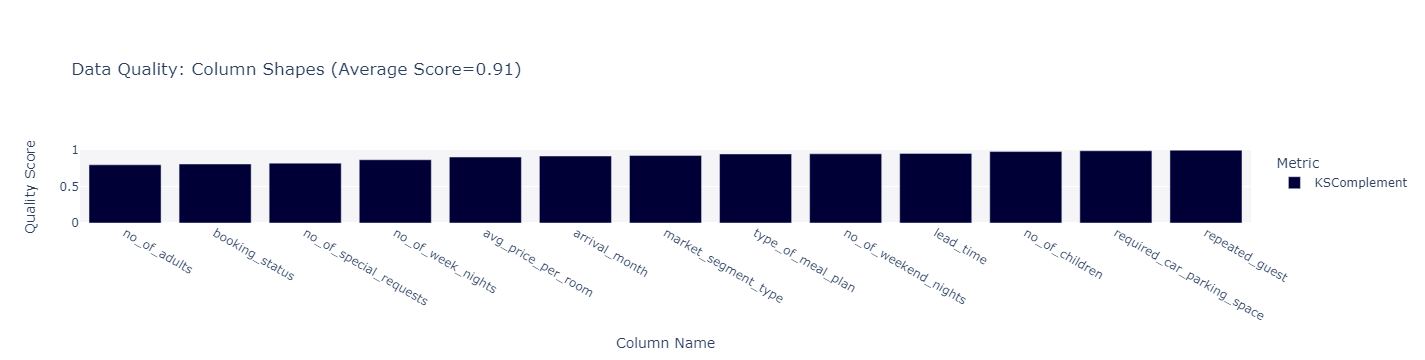

In [114]:
quality_report.get_visualization("Column Shapes")

#### CopulaGAN

In [115]:
synthesizer = CopulaGANSynthesizer(metadata)
# synthesizer.add_constraints(constraints=[date_constraint])

In [116]:
start_time = time.time()

synthesizer.fit(df)

end_time = time.time()

copula_time = round(end_time - start_time, 3)

In [117]:
copula_time

788.613

In [118]:
synthesizer.save("models/hotel_reservations/CopulaGAN_synthesizer.pkl")

In [119]:
synthesizer = CopulaGANSynthesizer.load(
    "models/hotel_reservations/CopulaGAN_synthesizer.pkl"
)

In [120]:
df_synth = synthesizer.sample(1000)

In [121]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.82it/s]


Overall Quality Score: 89.06%

Properties:
Column Shapes: 83.18%
Column Pair Trends: 94.95%


In [122]:
diagnostic_report = run_diagnostic(
    real_data=df, synthetic_data=df_synth, metadata=metadata
)

diagnostic_report

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.22s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [123]:
copula_score = quality_report.get_score()
copula_score = round(copula_score, 3)
copula_score

0.891

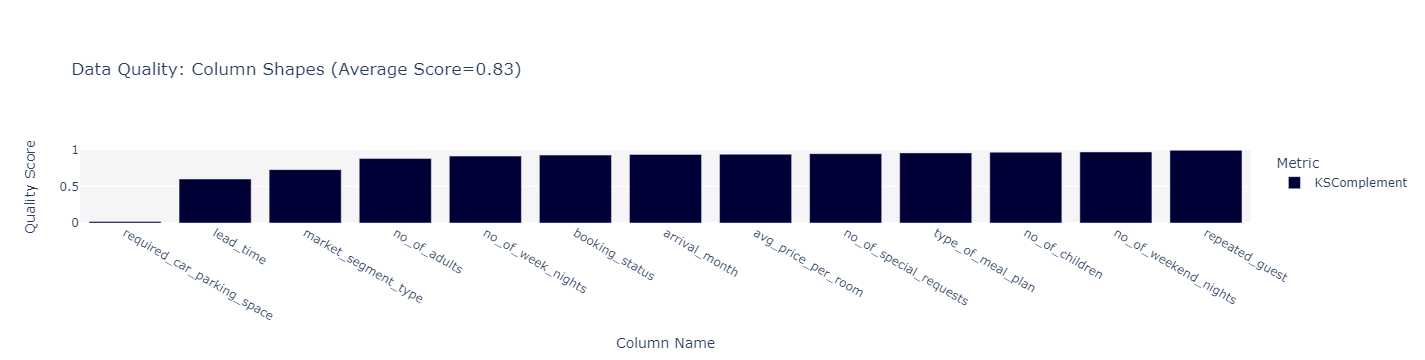

In [124]:
quality_report.get_visualization("Column Shapes")

#### GaussianCopula

In [125]:
synthesizer = GaussianCopulaSynthesizer(metadata)
# synthesizer.add_constraints(constraints=[date_constraint])

In [126]:
start_time = time.time()

synthesizer.fit(df)

end_time = time.time()

gaussian_time = round(end_time - start_time, 3)

In [127]:
gaussian_time

1.394

In [128]:
synthesizer.save("models/hotel_reservations/GaussianCopula_synthesizer.pkl")

In [129]:
synthesizer = GaussianCopulaSynthesizer.load(
    "models/hotel_reservations/GaussianCopula_synthesizer.pkl"
)

In [130]:
df_synth = synthesizer.sample(1000)

In [131]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.70it/s]


Overall Quality Score: 82.45%

Properties:
Column Shapes: 68.48%
Column Pair Trends: 96.42%


In [132]:
diagnostic_report = run_diagnostic(
    real_data=df, synthetic_data=df_synth, metadata=metadata
)

diagnostic_report

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.18s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [133]:
gaussian_score = quality_report.get_score()
gaussian_score = round(gaussian_score, 3)
gaussian_score

0.825

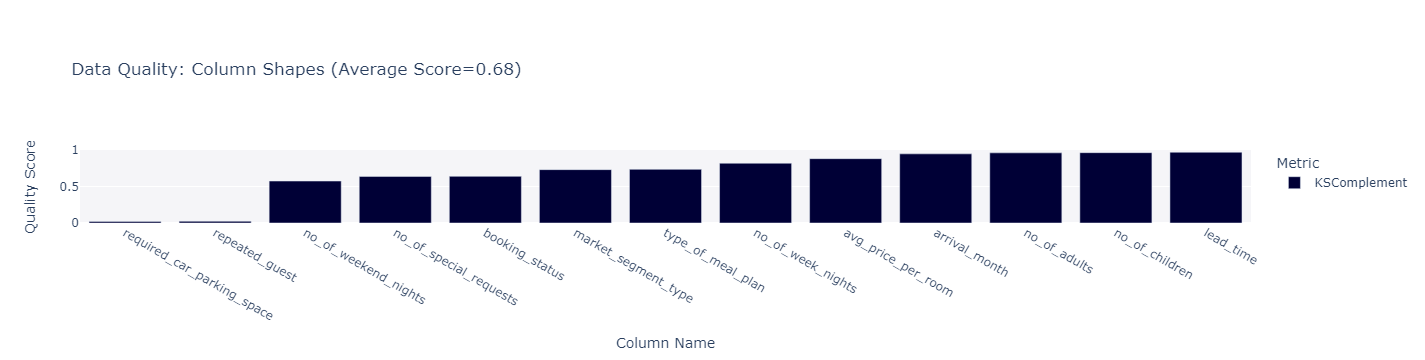

In [134]:
quality_report.get_visualization("Column Shapes")

#### TVAE

In [135]:
synthesizer = TVAESynthesizer(metadata)
# synthesizer.add_constraints(constraints=[date_constraint])

In [136]:
start_time = time.time()

synthesizer.fit(df)

end_time = time.time()

tvae_time = round(end_time - start_time, 3)

In [137]:
tvae_time

136.643

In [138]:
synthesizer.save("models/hotel_reservations/TVAE_synthesizer.pkl")

In [139]:
synthesizer = TVAESynthesizer.load("models/hotel_reservations/TVAE_synthesizer.pkl")

In [140]:
df_synth = synthesizer.sample(1000)

In [141]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.42it/s]


Overall Quality Score: 89.28%

Properties:
Column Shapes: 84.3%
Column Pair Trends: 94.26%


In [142]:
diagnostic_report = run_diagnostic(
    real_data=df, synthetic_data=df_synth, metadata=metadata
)

diagnostic_report

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.14s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [143]:
tvae_score = quality_report.get_score()
tvae_score = round(tvae_score, 3)
tvae_score

0.893

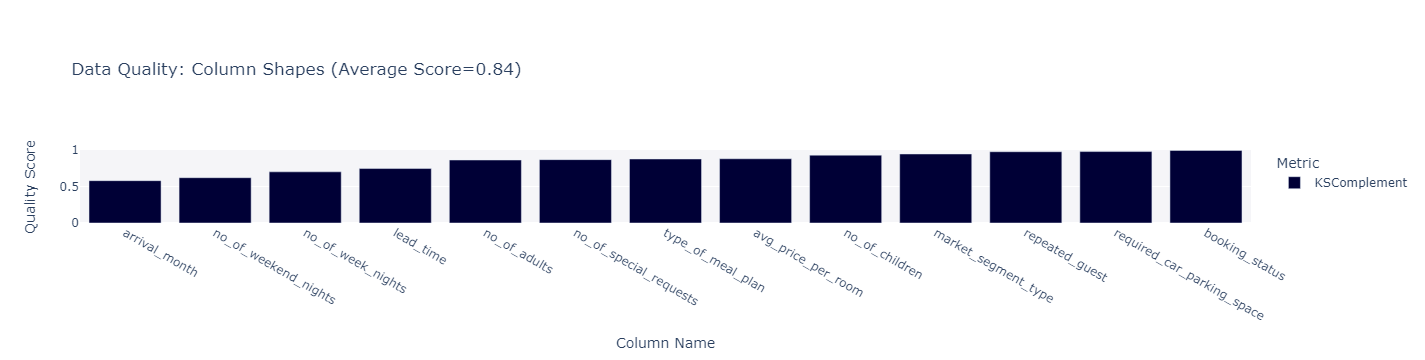

In [144]:
quality_report.get_visualization("Column Shapes")

#### FastML

In [145]:
synthesizer = SingleTablePreset(metadata, name="FAST_ML")
# synthesizer.add_constraints(constraints=[date_constraint])

In [146]:
start_time = time.time()

synthesizer.fit(df)

end_time = time.time()

fast_time = round(end_time - start_time, 3)

In [147]:
fast_time

0.112

In [148]:
synthesizer.save("models/hotel_reservations/FastML_synthesizer.pkl")

In [149]:
synthesizer = SingleTablePreset.load("models/hotel_reservations/FastML_synthesizer.pkl")

In [150]:
df_synth = synthesizer.sample(1000)

In [151]:
quality_report = evaluate_quality(df, df_synth, metadata)

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.38it/s]


Overall Quality Score: 95.46%

Properties:
Column Shapes: 93.62%
Column Pair Trends: 97.29%


In [152]:
diagnostic_report = run_diagnostic(
    real_data=df, synthetic_data=df_synth, metadata=metadata
)

diagnostic_report

Creating report: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.23s/it]


DiagnosticResults:

SUCCESS:
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [153]:
fast_score = quality_report.get_score()
fast_score = round(fast_score, 3)
fast_score

0.955

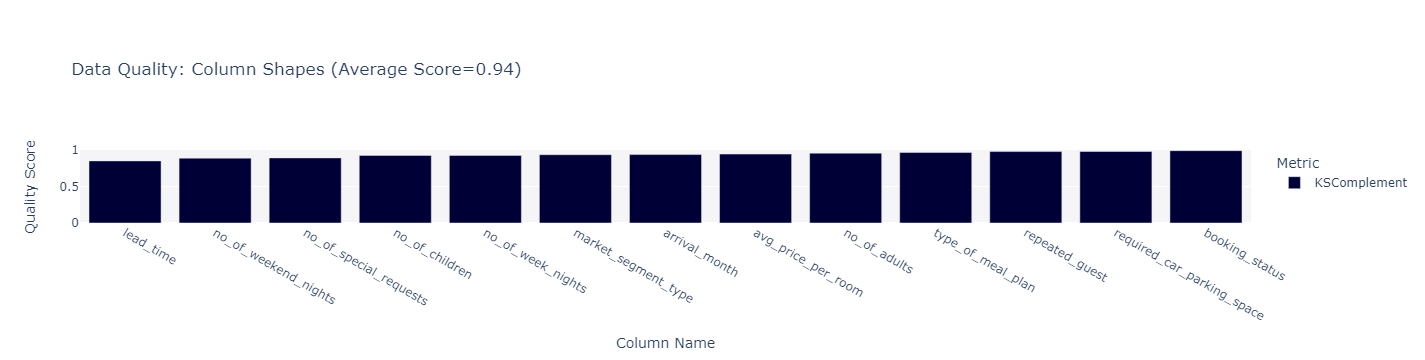

In [154]:
quality_report.get_visualization("Column Shapes")

### Análise da Geração dos Dados Sintéticos

In [155]:
data_score = {
    "Model": ["FastML", "TVAE", "GaussianCopula", "CopulaGAN", "CTGAN"],
    "Score": [fast_score, tvae_score, gaussian_score, copula_score, ctgan_score],
    "Time": [fast_time, tvae_time, gaussian_time, copula_time, ctgan_time],
}

df_score = pd.DataFrame(data_score)
df_score.sort_values(by="Score", ascending=False)

Model  Score     Time
0          FastML  0.955    0.112
4           CTGAN  0.930  733.016
1            TVAE  0.893  136.643
3       CopulaGAN  0.891  788.613
2  GaussianCopula  0.825    1.394

In [156]:
synthesizer = SingleTablePreset.load("models/hotel_reservations/FastML_synthesizer.pkl")
df_synth = synthesizer.sample(1000)
df_synth

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0               2               0                     1                  2   
1               3               1                     1                  1   
2               2               0                     0                  4   
3               2               0                     2                  5   
4               2               1                     1                  1   
..            ...             ...                   ...                ...   
995             2               0                     0                  4   
996             3               0                     1                  0   
997             3               0                     1                  5   
998             2               0                     2                  3   
999             1               1                     0                  3   

     type_of_meal_plan  required_car_parking_space  lead_time  arrival_month  \
0                    1                           0        153              8   
1                    1                           0        145              4   
2                    1                           0        102              2   
3                    1                           0        188              8   
4                    2                           0        202             10   
..                 ...                         ...        ...            ...   
995                  0                           0          0              9   
996                  1                           0         52              4   
997                  2                           0         13              8   
998                  1                           0        193              8   
999                  1                           0         49              6   

     market_segment_type  repeated_guest  avg_price_per_room  \
0                      0               0          168.443802   
1                      1               0           90.239472   
2                      2               0           99.601271   
3                      1               0           71.514244   
4                      1               0           61.896577   
..                   ...             ...                 ...   
995                    2               0          114.714105   
996                    1               0          113.994220   
997                    2               0          101.607178   
998                    0               0          161.720337   
999                    0               0           98.100557   

     no_of_special_requests  booking_status  
0                         1               1  
1                         1               1  
2                         1               0  
3                         1               1  
4                         1               1  
..                      ...             ...  
995                       0               1  
996                       0               0  
997                       2               0  
998                       1               1  
999                       0               0  

[1000 rows x 13 columns]

In [157]:
df_synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                1000 non-null   int64  
 1   no_of_children              1000 non-null   int64  
 2   no_of_weekend_nights        1000 non-null   int64  
 3   no_of_week_nights           1000 non-null   int64  
 4   type_of_meal_plan           1000 non-null   int64  
 5   required_car_parking_space  1000 non-null   int64  
 6   lead_time                   1000 non-null   int64  
 7   arrival_month               1000 non-null   int64  
 8   market_segment_type         1000 non-null   int64  
 9   repeated_guest              1000 non-null   int64  
 10  avg_price_per_room          1000 non-null   float64
 11  no_of_special_requests      1000 non-null   int64  
 12  booking_status              1000 non-null   int64  
dtypes: float64(1), int64(12)
memory us

### Comparação Dados Reais vs. Dados Sintéticos

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                2000 non-null   int64  
 1   no_of_children              2000 non-null   int64  
 2   no_of_weekend_nights        2000 non-null   int64  
 3   no_of_week_nights           2000 non-null   int64  
 4   type_of_meal_plan           2000 non-null   int64  
 5   required_car_parking_space  2000 non-null   int64  
 6   lead_time                   2000 non-null   int64  
 7   arrival_month               2000 non-null   int64  
 8   market_segment_type         2000 non-null   int64  
 9   repeated_guest              2000 non-null   int64  
 10  avg_price_per_room          2000 non-null   float64
 11  no_of_special_requests      2000 non-null   int64  
 12  booking_status              2000 non-null   int64  
dtypes: float64(1), int64(12)
memory u

In [159]:
df_synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                1000 non-null   int64  
 1   no_of_children              1000 non-null   int64  
 2   no_of_weekend_nights        1000 non-null   int64  
 3   no_of_week_nights           1000 non-null   int64  
 4   type_of_meal_plan           1000 non-null   int64  
 5   required_car_parking_space  1000 non-null   int64  
 6   lead_time                   1000 non-null   int64  
 7   arrival_month               1000 non-null   int64  
 8   market_segment_type         1000 non-null   int64  
 9   repeated_guest              1000 non-null   int64  
 10  avg_price_per_room          1000 non-null   float64
 11  no_of_special_requests      1000 non-null   int64  
 12  booking_status              1000 non-null   int64  
dtypes: float64(1), int64(12)
memory us

### TSNE

In [160]:
X = pd.concat([df, df_synth], axis=0)
y = pd.Series([0] * len(df) + [1] * len(df_synth))

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

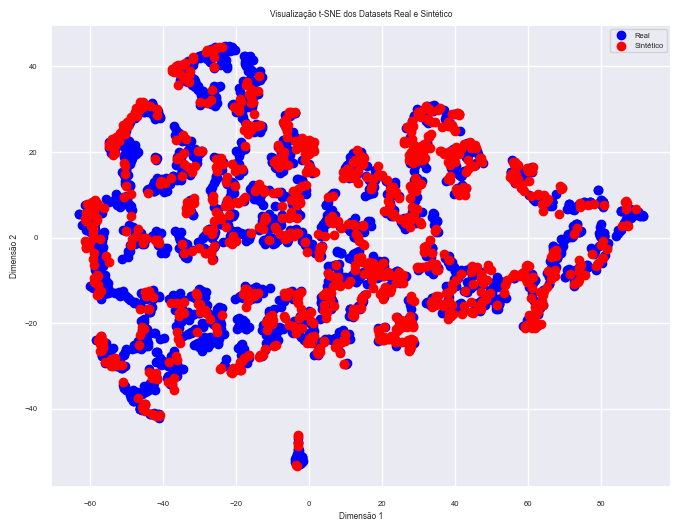

In [161]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[y == 0][:, 0], X_tsne[y == 0][:, 1], label="Real", c="blue")
plt.scatter(X_tsne[y == 1][:, 0], X_tsne[y == 1][:, 1], label="Sintético", c="red")
plt.legend()
plt.title("Visualização t-SNE dos Datasets Real e Sintético")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.show()

In [91]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X_tsne[y == 0][:, 0], bins=50, color="blue", alpha=0.7, label="Real")
plt.hist(X_tsne[y == 1][:, 0], bins=50, color="red", alpha=0.7, label="Sintético")
plt.title("Histograma da Dimensão 1 t-SNE")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(X_tsne[y == 0][:, 1], bins=50, color="blue", alpha=0.7, label="Real")
plt.hist(X_tsne[y == 1][:, 1], bins=50, color="red", alpha=0.7, label="Sintético")
plt.title("Histograma da Dimensão 2 t-SNE")
plt.legend()

plt.show()

## Processos de Classificação

In [84]:
cat_features = [
    "type_of_meal_plan",
    "room_type_reserved",
    "market_segment_type",
    "booking_status",
]

### Apenas com os Dados Reais

In [219]:
df = pd.read_csv("data/hotel_reservations/hotel_reservations.csv")
df = adjust_dataframe(df)
df.drop(
    columns=[
        "room_type_reserved",
        "arrival_year",
        "arrival_date",
        "no_of_previous_cancellations",
        "no_of_previous_bookings_not_canceled",
    ],
    inplace=True,
)

In [220]:
df_real = df.copy()

In [221]:
df_class_0 = df[df["booking_status"] == 0]
df_class_1 = df[df["booking_status"] == 1]

df_class_0_reduced = df_class_0.sample(frac=0.2, random_state=42)
df_class_1_reduced = df_class_1.sample(frac=0.2, random_state=42)
df = pd.concat([df_class_0_reduced, df_class_1_reduced])

In [222]:
df_copy = df.copy()

#### Pre-processamento utilizando OneHotEncoder

In [223]:
# dummy_variables = dummy(df, cat_features)
# df = pd.concat([df] + dummy_variables, axis=1)
# df = df.drop(cat_features, axis=1)

#### Divisão Treino e Teste

In [224]:
y = df["booking_status"]
X = df.drop("booking_status", axis=1)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [226]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (280, 12) 
X_test: (120, 12) 
y_train: (280,) 
y_test: (120,)


#### Avaliação dos Modelos apenas com Dados Reais

In [227]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True)
results_df

Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.641667  0.605634  0.666667  0.644883   0.274031   
1        Decision Tree  0.633333  0.606061  0.645161  0.635150   0.196000   
2                  KNN  0.650000  0.611111  0.676923  0.653504   0.178002   
3        Random Forest  0.683333  0.661290  0.683333  0.684093  11.335998   
4  Logistic Regression  0.691667  0.656716  0.704000  0.693826   0.239008   
5                  MLP  0.666667  0.628571  0.687500  0.669633  23.676992   

                                  Best Parameters  
0                     {'C': 0.5, 'kernel': 'rbf'}  
1        {'max_depth': 5, 'min_samples_split': 2}  
2      {'n_neighbors': 10, 'weights': 'distance'}  
3        {'max_depth': None, 'n_estimators': 100}  
4               {'C': 0.5, 'solver': 'liblinear'}  
5  {'alpha': 0.001, 'hidden_layer_sizes': (100,)}

### Incrementação Dados Sintéticos + Reais

In [228]:
df.booking_status.value_counts()

0    200
1    200
Name: booking_status, dtype: int64

In [229]:
synthesizer = SingleTablePreset.load("models/hotel_reservations/FastML_synthesizer.pkl")
balanced_conditions_0 = Condition(
    num_rows=df.booking_status.value_counts()[0], column_values={"booking_status": 0}
)
balanced_conditions_1 = Condition(
    num_rows=df.booking_status.value_counts()[1], column_values={"booking_status": 1}
)

In [230]:
df_synth = synthesizer.sample_from_conditions(
    conditions=[balanced_conditions_1, balanced_conditions_0]
)
df_synth

Sampling conditions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 2720.50it/s]


no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0               1               0                     2                  2   
1               2               0                     0                  3   
2               3               1                     1                  2   
3               2               0                     3                  3   
4               1               0                     2                  3   
..            ...             ...                   ...                ...   
395             3               0                     2                  4   
396             2               0                     1                  3   
397             2               0                     2                  3   
398             2               0                     0                  3   
399             2               0                     1                  4   

     type_of_meal_plan  required_car_parking_space  lead_time  arrival_month  \
0                    0                           0        154              5   
1                    1                           0        114              3   
2                    1                           0         72              7   
3                    2                           0        118              5   
4                    1                           0        168              8   
..                 ...                         ...        ...            ...   
395                  1                           0         25              7   
396                  1                           0          0              6   
397                  1                           0         25             11   
398                  1                           0        159              9   
399                  1                           0          7              7   

     market_segment_type  repeated_guest  avg_price_per_room  \
0                      0               0           90.454463   
1                      0               0          100.032052   
2                      1               0          177.819638   
3                      1               0          127.064708   
4                      0               0          111.104006   
..                   ...             ...                 ...   
395                    1               0          122.719245   
396                    0               0          161.022569   
397                    1               0           79.969666   
398                    1               0           95.263249   
399                    0               0          112.757312   

     no_of_special_requests  booking_status  
0                         0               1  
1                         0               1  
2                         1               1  
3                         0               1  
4                         0               1  
..                      ...             ...  
395                       2               0  
396                       1               0  
397                       0               0  
398                       0               0  
399                       0               0  

[400 rows x 13 columns]

In [231]:
df_new = pd.concat([df_copy, df_synth])

In [232]:
df_new.booking_status.value_counts()

0    400
1    400
Name: booking_status, dtype: int64

#### Pre-processamento utilizando OneHotEncoder

In [233]:
# dummy_variables = dummy(df_new, cat_features)
# df_new = pd.concat([df_new] + dummy_variables, axis=1)
# df_new = df_new.drop(cat_features, axis=1)

In [234]:
df_new

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
521             2               0                     0                  3   
737             1               0                     2                  0   
740             1               0                     1                  0   
660             2               0                     0                  4   
411             3               0                     2                  3   
..            ...             ...                   ...                ...   
395             3               0                     2                  4   
396             2               0                     1                  3   
397             2               0                     2                  3   
398             2               0                     0                  3   
399             2               0                     1                  4   

     type_of_meal_plan  required_car_parking_space  lead_time  arrival_month  \
521                  1                           0         23             12   
737                  1                           0         61             10   
740                  1                           0          6             10   
660                  1                           0         49             12   
411                  1                           0         23              4   
..                 ...                         ...        ...            ...   
395                  1                           0         25              7   
396                  1                           0          0              6   
397                  1                           0         25             11   
398                  1                           0        159              9   
399                  1                           0          7              7   

     market_segment_type  repeated_guest  avg_price_per_room  \
521                    1               0          108.670000   
737                    0               0           73.000000   
740                    2               1           65.000000   
660                    0               0           71.000000   
411                    1               0          146.200000   
..                   ...             ...                 ...   
395                    1               0          122.719245   
396                    0               0          161.022569   
397                    1               0           79.969666   
398                    1               0           95.263249   
399                    0               0          112.757312   

     no_of_special_requests  booking_status  
521                       1               0  
737                       0               0  
740                       0               0  
660                       0               0  
411                       3               0  
..                      ...             ...  
395                       2               0  
396                       1               0  
397                       0               0  
398                       0               0  
399                       0               0  

[800 rows x 13 columns]

#### Divisão Treino e Teste

In [235]:
y = df_new["booking_status"]
X = df_new.drop("booking_status", axis=1)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [237]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (560, 12) 
X_test: (240, 12) 
y_train: (560,) 
y_test: (240,)


#### Avaliação dos Modelos com Dados Incrementados

In [238]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True)
results_df

Classificador  Acurácia  Precisão  F1 Score   ROC/AUC      Tempo  \
0                  SVM  0.745833  0.722689  0.738197  0.746241   0.658006   
1        Decision Tree  0.712500  0.689076  0.703863  0.712824   0.230026   
2                  KNN  0.695833  0.661417  0.697095  0.697786   0.281000   
3        Random Forest  0.766667  0.763636  0.750000  0.765246  13.386000   
4  Logistic Regression  0.720833  0.704348  0.707424  0.720343   0.446007   
5                  MLP  0.679167  0.645669  0.680498  0.681078  41.207959   

                                  Best Parameters  
0                    {'C': 1, 'kernel': 'linear'}  
1        {'max_depth': 5, 'min_samples_split': 5}  
2      {'n_neighbors': 10, 'weights': 'distance'}  
3          {'max_depth': 10, 'n_estimators': 100}  
4                     {'C': 0.1, 'solver': 'sag'}  
5  {'alpha': 0.001, 'hidden_layer_sizes': (100,)}

### TSTR (Train with Synthetic, Test with Real)

In [239]:
df = pd.read_csv("data/hotel_reservations/hotel_reservations.csv")
df = adjust_dataframe(df)
df.drop(
    columns=[
        "room_type_reserved",
        "arrival_year",
        "arrival_date",
        "no_of_previous_cancellations",
        "no_of_previous_bookings_not_canceled",
    ],
    inplace=True,
)

synthesizer = SingleTablePreset.load("models/hotel_reservations/FastML_synthesizer.pkl")
df_synth = synthesizer.sample(df.shape[0])

In [240]:
df_synth

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                2               0                     1                  2   
1                3               1                     1                  1   
2                2               0                     0                  4   
3                2               0                     2                  5   
4                2               1                     1                  1   
...            ...             ...                   ...                ...   
1995             2               0                     1                  3   
1996             2               0                     1                  3   
1997             2               1                     2                  2   
1998             1               1                     0                  2   
1999             2               0                     2                  4   

      type_of_meal_plan  required_car_parking_space  lead_time  arrival_month  \
0                     1                           0        153              8   
1                     1                           0        145              4   
2                     1                           0        102              2   
3                     1                           0        188              8   
4                     2                           0        202             10   
...                 ...                         ...        ...            ...   
1995                  1                           0        150              9   
1996                  2                           0        273              6   
1997                  1                           0        100              7   
1998                  0                           0         37              9   
1999                  2                           0        222              6   

      market_segment_type  repeated_guest  avg_price_per_room  \
0                       0               0          168.443802   
1                       1               0           90.239472   
2                       2               0           99.601271   
3                       1               0           71.514244   
4                       1               0           61.896577   
...                   ...             ...                 ...   
1995                    1               0          108.533452   
1996                    0               0          114.716633   
1997                    1               0          146.689110   
1998                    0               0           85.159523   
1999                    1               0           98.750300   

      no_of_special_requests  booking_status  
0                          1               1  
1                          1               1  
2                          1               0  
3                          1               1  
4                          1               1  
...                      ...             ...  
1995                       1               1  
1996                       1               0  
1997                       0               1  
1998                       0               0  
1999                       1               0  

[2000 rows x 13 columns]

#### Pre-processamento utilizando OneHotEncoder

In [241]:
# dummy_variables = dummy(df, cat_features)
# df = pd.concat([df] + dummy_variables, axis=1)
# df = df.drop(cat_features, axis=1)

In [242]:
# dummy_variables = dummy(df_synth, cat_features)
# df_synth = pd.concat([df_synth] + dummy_variables, axis=1)
# df_synth = df_synth.drop(cat_features, axis=1)

#### Divisão Treino e Teste

In [243]:
# X_train e y_train como os dados sintéticos (df_synth)
X_train = df_synth.drop("booking_status", axis=1)
y_train = df_synth["booking_status"]

# X_test e y_test como os dados reais (df)
X_test = df.drop("booking_status", axis=1)
y_test = df["booking_status"]

In [244]:
print(
    f"X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}"
)

X_train: (2000, 12) 
X_test: (2000, 12) 
y_train: (2000,) 
y_test: (2000,)


#### Avaliação dos Modelos TSTR

In [245]:
results_df = evaluate_models(X_train, X_test, y_train, y_test, standardscaler=True)
results_df

Classificador  Acurácia  Precisão  F1 Score  ROC/AUC       Tempo  \
0                  SVM    0.7450  0.789598  0.723727   0.7450    8.162405   
1        Decision Tree    0.6755  0.774648  0.604027   0.6755    0.527898   
2                  KNN    0.6515  0.701195  0.602396   0.6515    1.813487   
3        Random Forest    0.7180  0.775253  0.685268   0.7180   21.360598   
4  Logistic Regression    0.7520  0.788991  0.735043   0.7520    1.971962   
5                  MLP    0.6410  0.665105  0.612729   0.6410  142.574822   

                                 Best Parameters  
0                 {'C': 0.5, 'kernel': 'linear'}  
1       {'max_depth': 1, 'min_samples_split': 2}  
2      {'n_neighbors': 10, 'weights': 'uniform'}  
3          {'max_depth': 5, 'n_estimators': 200}  
4                    {'C': 0.1, 'solver': 'sag'}  
5  {'alpha': 0.01, 'hidden_layer_sizes': (100,)}